We will use the sam simple cnn but now their will be no leakadge at all. I expect this to perform very poorly

In [1]:
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


from combined_data_script import get_data
from medication_data_script import LeakageOption


In [59]:
data_dic = get_data(flatten=False,leakage_option=LeakageOption.NO_LEAKAGE, stride=50)

In [3]:
train, dev, test = data_dic['train'], data_dic['dev'], data_dic['test'] 

In [4]:
len(train) #note it is NOT shuffled we will nedd to do this

10462

when we were useing the mlp the data needed to be flattened but not we waste to have it separated so lets make sure the tensor size is correct

In [5]:
X0, y0 = train[0]
X0.shape

torch.Size([6, 400])

In [6]:
#important that we shuffle THEY ARE NOT IF WE DONT
torch.manual_seed(69)
train_loader = DataLoader(train, batch_size=2048, shuffle=True)
dev_loader = DataLoader(dev, batch_size=2048, shuffle=True)

In [7]:
class simple_cnn(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.c0  = nn.Conv1d(6, 64, kernel_size=3, stride=2)

        self.c1  = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.c2  = nn.Conv1d(128, 128, kernel_size=3)

        self.c3  = nn.Conv1d(128, 256, kernel_size=3, stride=2)
        self.c4  = nn.Conv1d(256, 256, kernel_size=3)
        self.c5  = nn.Conv1d(256, 256, kernel_size=3)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.l0 = nn.Linear(256,256)
        self.dropout = nn.Dropout(p=dropout)
        self.out = nn.Linear(256,1)
         
        
    def forward(self, x):
        x = F.relu(self.c0(x), inplace=True)
        
        x = F.relu(self.c1(x), inplace=True)
        x = F.relu(self.c2(x), inplace=True)
        
        x = F.relu(self.c3(x), inplace=True)
        x = F.relu(self.c4(x), inplace=True)
        x = F.relu(self.c5(x), inplace=True)
        
        x = self.gap(x).squeeze(-1)
        x = F.relu(self.l0(x), inplace=True)
        x = self.dropout(x)
        x = self.out(x)
        
        return x
    

In [8]:
dropout = 0.4
model = simple_cnn(dropout=dropout)

device = "mps"
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.0003)

In [9]:
lossi = []
devlossi = []

best_dev_loss = float('inf')
best_model = None

In [55]:
for epoch in tqdm(range(10)):
    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) 

        logits = model(X_batch)
        loss = criterion(logits, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    lossi.append(loss_total / len(train_loader))

    with torch.no_grad():
        dev_loss_total = 0
        for X_dev, y_dev in dev_loader:
            X_dev, y_dev = X_dev.to(device), y_dev.to(device) 

            dev_logits = model(X_dev)
            dev_loss = criterion(dev_logits, y_dev.float())
            dev_loss_total += dev_loss.item()

    current_dev_loss = dev_loss_total / len(dev_loader)
    devlossi.append(current_dev_loss)
    
    if current_dev_loss < best_dev_loss:
        best_dev_loss = current_dev_loss
        best_model = type(model)(dropout=dropout)
        best_model.load_state_dict(model.state_dict())

print(f"best dev loss is {best_dev_loss:.4f}")

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

best dev loss is 0.2461


Text(0.5, 1.0, 'NO data leakadge')

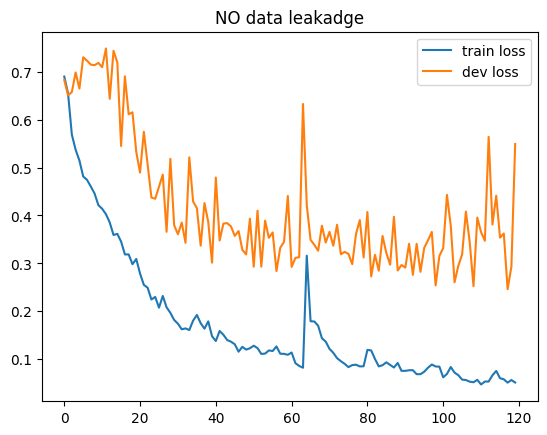

In [56]:
plt.plot(lossi, label='train loss')
plt.plot(devlossi, label='dev loss')
plt.legend()
plt.title('NO data leakadge')

In [57]:
pred_logits = best_model(X_dev.cpu())

preds = pred_logits.cpu()
preds = (preds > 0.5).float()

In [58]:
print(classification_report(y_dev.cpu().numpy(), preds))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       462
           1       0.96      0.89      0.92       462

    accuracy                           0.93       924
   macro avg       0.93      0.93      0.93       924
weighted avg       0.93      0.93      0.93       924



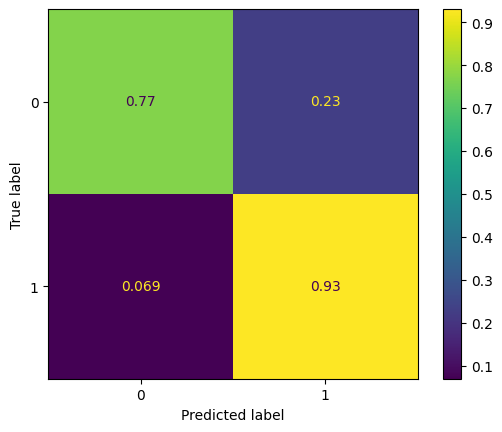

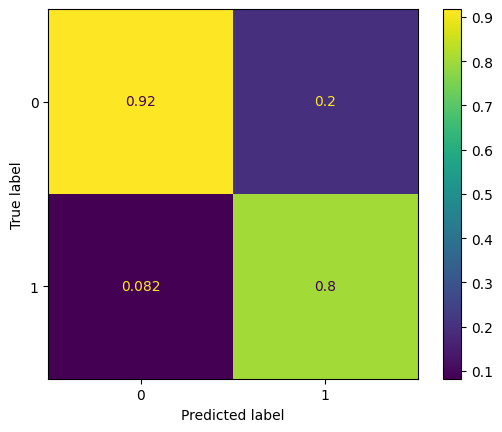

In [27]:
ConfusionMatrixDisplay.from_predictions(y_dev.cpu().numpy(), preds, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_dev.cpu().numpy(), preds, normalize='pred')

we do better with no leakadge????